# Walmart Weekly Sales Prediction Model

## Introduction

The dataset used in this analysis was provided by Walmart to Kaggle to host a competition where participants were tasked with creating a model that can predict weekly sales. Before creating a regression model, an exploratory data analysis (EDA) will be undertaken to gain insight into the data provided. Its important to note that no metadata was provided for this set, so store type, department number and the details for markdown 1-5 could not be discerned.

## Data Ethics

This dataset is ethical, it does not publicize any individuals personal info and has been obtained through Walmart's internal data collection methods and will only be used for the purpose of displaying analytical capabilities and not joined or merged with any outside sources or databases.

## Question & Hypothesis

Do external factors like temperature, holiday times, fuel prices and unemployment effect weekly sales?

Hypothesis: Yes, influences outside of the control of a given store have an effect on weekly sales.

## Importing Libraries and Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from numpy import ones #used to add a constant in the linear regressions
from google.cloud import bigquery #dataset is housed on Google BigQuery
from missingno import matrix #only need this single function from the Miissingno Library

#For Regression Modeling 
import datetime as dt
from sklearn.model_selection import train_test_split # importing the train_test_split function from sklearn
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree, DecisionTreeClassifier, DecisionTreeRegressor #to visualize the regression tree

features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

### BigQuery Code Import

In [2]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/Users/Victor Silvano/Documents/Juno/Bootcamp/Projects/Project_ 4_Capstone/walmart-sales-prediction-045364f86b13.json'
client = bigquery.Client()

The first step is to import the raw tables from BigQuery using SQL.

In [3]:
query1 = """
SELECT
    *
FROM `walmart-sales-prediction.WalmartSalesData.stores`
ORDER BY Store
"""

In [4]:
query_job = client.query(query1)
stores = query_job.to_dataframe()

In [5]:
query2 =  """
SELECT
    *
FROM `walmart-sales-prediction.WalmartSalesData.training_data_for_model`
ORDER BY Store, Date
"""

In [6]:
query_job = client.query(query2)
train = query_job.to_dataframe()

In [7]:
query3 =  """
SELECT
    *
FROM `walmart-sales-prediction.WalmartSalesData.features`
ORDER BY Store, Date
"""

In [8]:
query_job = client.query(query3)
features = query_job.to_dataframe()

A total of 3 tables were imported: features, stores and train.

# EDA

## Stores

Shape, DType, Tail/head methods used to get an idea of the contents of the datasets and an investigation into null values will also be done in this section. BigQuery imported missing values as NA rather then np.NaN so each table had its NA values converted to np.NaN to facilitate the null value investigation.

In [9]:
stores.shape

(45, 3)

In [10]:
stores.dtypes

Store     int64
Type     object
Size      int64
dtype: object

In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [13]:
stores = stores.replace('NA', np.nan)

In [14]:
pd.isna(stores).sum()

Store    0
Type     0
Size     0
dtype: int64

In [15]:
stores.Type.unique()

array(['A', 'B', 'C'], dtype=object)

In [16]:
stores.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

There are a total of 45 stores split into three types  A, B, C.

## Train

In [17]:
train.shape

(421570, 5)

In [18]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [19]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,2,2010-02-05,50605.27,False
2,1,3,2010-02-05,13740.12,False
3,1,4,2010-02-05,39954.04,False
4,1,5,2010-02-05,32229.38,False


In [20]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,93,2012-10-26,2487.80,False
421566,45,94,2012-10-26,5203.31,False
421567,45,95,2012-10-26,56017.47,False
421568,45,97,2012-10-26,6817.48,False
421569,45,98,2012-10-26,1076.80,False


In [21]:
train = train.replace('NA', np.nan)

In [22]:
pd.isna(train).sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [23]:
#used to check if the ['Train'] dataset contains information for each location found in ['Store']
stores.Store.unique() == train.Store.unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [24]:
train.Dept.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92,
       93, 94, 95, 97, 98, 78, 96, 99, 77, 39, 50, 43, 65], dtype=int64)

In [25]:
train.Dept.unique().max()

99

Not all stores have the same number of departments, with the largest store having 99, but due to the lack of meta data on what each department signifies they will be ignored in order to sum across store and week to align with the features data so a more comprehensive investigation can occur.

## Features

In [26]:
features.shape

(8190, 12)

In [27]:
features.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1        object
MarkDown2        object
MarkDown3        object
MarkDown4        object
MarkDown5        object
CPI              object
Unemployment     object
IsHoliday          bool
dtype: object

In [28]:
features.head(185)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,1,2010-02-12,38.51,2.548,NA,NA,NA,NA,NA,211.2421698,8.106,True
2,1,2010-02-19,39.93,2.514,NA,NA,NA,NA,NA,211.2891429,8.106,False
3,1,2010-02-26,46.63,2.561,NA,NA,NA,NA,NA,211.3196429,8.106,False
4,1,2010-03-05,46.50,2.625,NA,NA,NA,NA,NA,211.3501429,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
180,1,2013-07-19,79.26,3.556,3117.04,1060.39,199.05,1012.3,5381.72,NA,NA,False
181,1,2013-07-26,81.54,3.620,332.17,673.19,1,38.63,1245.2,NA,NA,False
182,2,2010-02-05,40.19,2.572,NA,NA,NA,NA,NA,210.7526053,8.324,False
183,2,2010-02-12,38.49,2.548,NA,NA,NA,NA,NA,210.8979935,8.324,True


In [29]:
features.tail(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3,2449.97,3169.69,NA,NA,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NA,NA,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NA,NA,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363,1059.46,NA,NA,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NA,NA,False


In [30]:
features = features.replace('NA', np.nan)

The final date recorded for each of the 45 stores on record is 2013-07-26, for 181 data points (weeks) worth of data.

In [31]:
pd.isna(features).sum() #used to check the number of NaN data found in the features set

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

<AxesSubplot:>

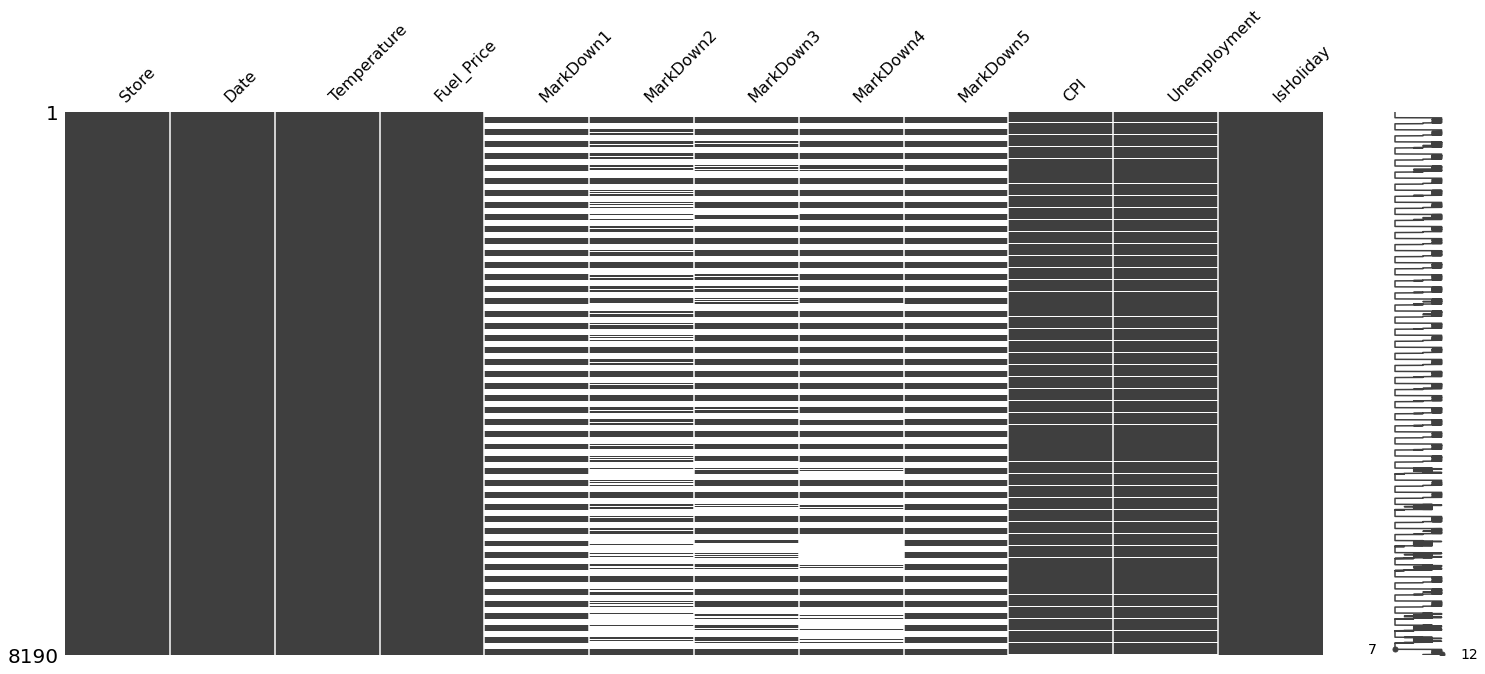

In [32]:
matrix(features) #imported from the missingno library to visualize the missing data

The NaNs in Markdown 1-5 are most likely used to signal there was no sale during this period, escentially zeros. 

When CPI information was unavailable the related unemployment information was also registered as NaN.

In [33]:
#Used to transform the NaNs in Markdown columns to 0 to make future plots more coherent
features[['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = features[['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

In [34]:
#recheck dataset
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


# Plots

## Data Preperation

In order to undergo a linear regression and further EDA using plots an aggregation of the [features], [store] and [train] tables is necessary. There will be some loss of data from the features table since the [train] data spans a smaller number of weeks then [features]. However this loss of data is considered acceptable since it will provide us with the weekly sales per store per week which is the most important data we have.

In [35]:
query_aggregate = """

WITH    
    Sum_of_Weekly_Sales AS -- Weekly Sales by store aggregated on a weekly basis, with the department information dropped
        (SELECT 
            Store,
            Date,
            ROUND(SUM(Weekly_Sales),2) as Sales,
        FROM `walmart-sales-prediction.WalmartSalesData.training_data_for_model` as td 
        GROUP BY Store, Date
        ),

    Features_With_Store_Type AS -- Join between the "Store" table with "Features" in order to add the Type of store to the features table
        (SELECT 
        f.Store as Store,
        f.Date as Date,
        Type as Store_Type,
        Temperature,
        Fuel_Price,
        CPI,
        Unemployment,
        IsHoliday
    FROM `walmart-sales-prediction.WalmartSalesData.features` as f
        JOIN `walmart-sales-prediction.WalmartSalesData.stores` as s
        on s.Store = f.Store
        )
    
-- Aggregation between 2 temporary tables made above, giving us player info alongside a retention check and money spent

SELECT
    Features_With_Store_Type.Store as Store,
    Features_With_Store_Type.Date as Date,
    Store_Type,
    Temperature,
    Fuel_Price,
    CPI,
    Unemployment,
    Sales,
    IsHoliday   
FROM Features_With_Store_Type
    JOIN Sum_of_Weekly_Sales
    ON Features_With_Store_Type.Date = Sum_of_Weekly_Sales.Date AND Features_With_Store_Type.Store = Sum_of_Weekly_Sales.Store
ORDER BY Store, Date

"""


In [36]:
query_job5 = client.query(query_aggregate)

In [37]:
# results as a dataframe
df = query_job5.result().to_dataframe()
df.head()

,Store,Date,Store_Type,Temperature,Fuel_Price,CPI,Unemployment,Sales,IsHoliday
0,1,2010-02-05,A,42.31,2.572,211.0963582,8.106,1643690.90,False
1,1,2010-02-12,A,38.51,2.548,211.2421698,8.106,1641957.44,True
2,1,2010-02-19,A,39.93,2.514,211.2891429,8.106,1611968.17,False
3,1,2010-02-26,A,46.63,2.561,211.3196429,8.106,1409727.59,False
4,1,2010-03-05,A,46.50,2.625,211.3501429,8.106,1554806.68,False


In [38]:
df.dtypes

Store             int64
Date             object
Store_Type       object
Temperature     float64
Fuel_Price      float64
CPI              object
Unemployment     object
Sales           float64
IsHoliday          bool
dtype: object

In [39]:
# Changing the CPI and Unemployment columns to float64
#df[['CPI','Unemployment']] = pd.to_numeric(df[['CPI','Unemployment']])
df['CPI'] = pd.to_numeric(df['CPI'])
df['Unemployment'] = pd.to_numeric(df['Unemployment'])

In [40]:
# The Date column is not being read as a datetime, so the below method is used to convert it
df['Date'] =  pd.to_datetime(df['Date'])

In [41]:
#quick look into key sstatistics across the entire dataset
round(df.describe(),2)

,Store,Temperature,Fuel_Price,CPI,Unemployment,Sales
count,6435.00,6435.00,6435.00,6435.00,6435.00,6435.00
mean,23.00,60.66,3.36,171.58,8.00,1046964.88
std,12.99,18.44,0.46,39.36,1.88,564366.62
min,1.00,-2.06,2.47,126.06,3.88,209986.25
25%,12.00,47.46,2.93,131.74,6.89,553350.10
50%,23.00,62.67,3.44,182.62,7.87,960746.04
75%,34.00,74.94,3.74,212.74,8.62,1420158.66
max,45.00,100.14,4.47,227.23,14.31,3818686.45


## Check distribution of sales

In [42]:
sns.set_style('darkgrid') #Set style to dark grid for readability

Text(0.5, 0.98, 'Sales')

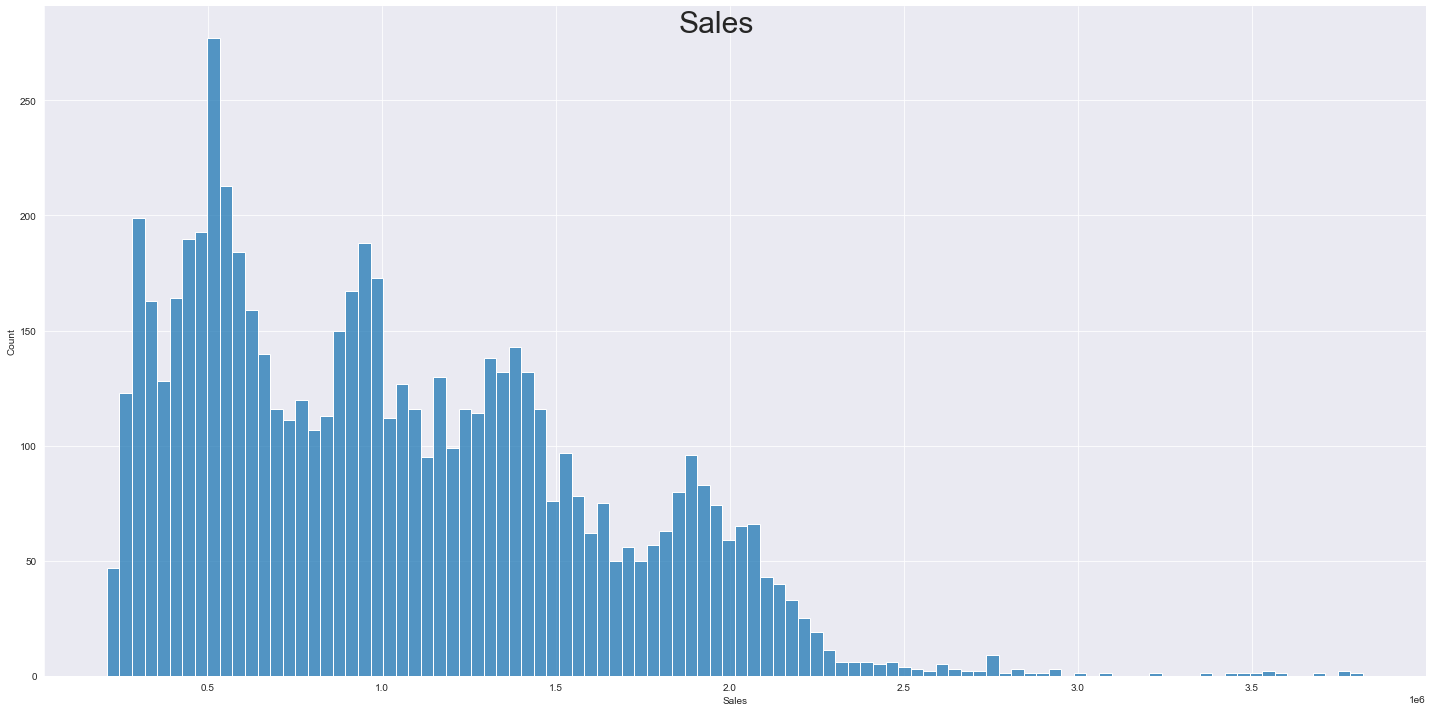

In [43]:
#used to check how sales are distributed across entire dataset
Train_Normal_Plot = sns.displot(df, x='Sales', bins=100, height=10, aspect=2)
#adds a title to the visual output
Train_Normal_Plot.fig.suptitle('Sales', fontsize=30)

Our sales data is normally distributed with a skew towards $500,000 / Week

In [44]:
#Breakdown of store type, total stores = 45
df[['Store','Store_Type']].drop_duplicates().groupby(by='Store_Type').count()

,Store
Store_Type,
A,22
B,17
C,6


<AxesSubplot:xlabel='Date', ylabel='Sales'>

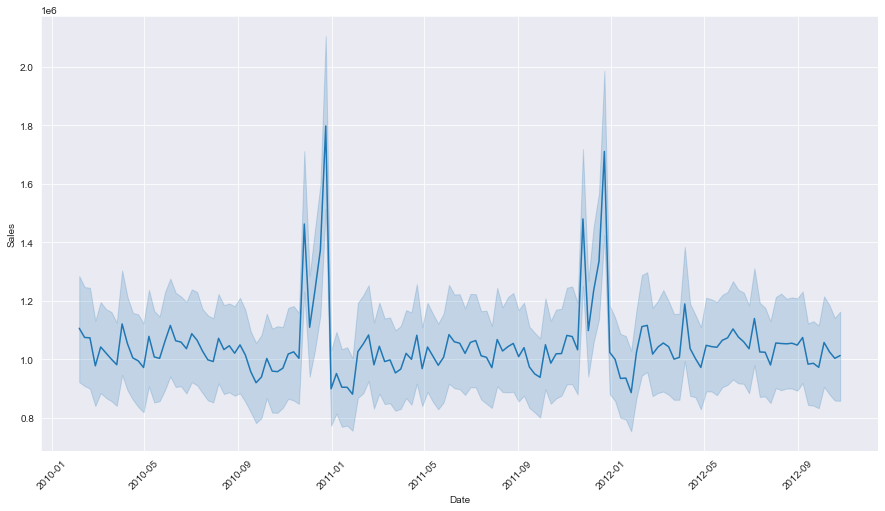

In [45]:
#Sales against Time
plt.figure(figsize=(15,8))
plt.xticks(rotation=45) #used to angle the ticks on x-axis for readability
sns.lineplot(data=df, x='Date', y='Sales')

As expected the months of November and December saw massive increases to sales in both 2011 and 2012 which aligns with the holiday season. 

<AxesSubplot:xlabel='Fuel_Price', ylabel='Sales'>

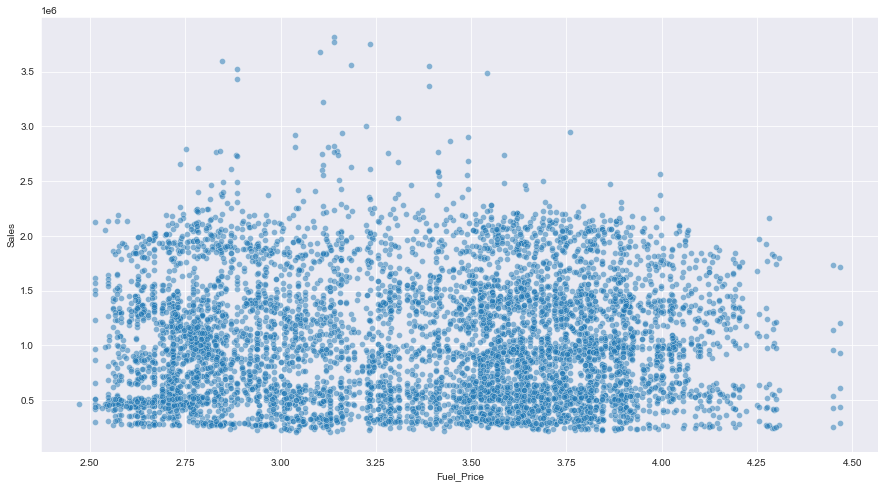

In [46]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x='Fuel_Price', y='Sales', alpha=0.5)

Several clusters seem to be present for the Fuel vs Sales graph, although as a whole the data is fairly evenly distributed aside from the gap between $3 and $3.5 Fuel_Price.

<AxesSubplot:xlabel='Temperature', ylabel='Sales'>

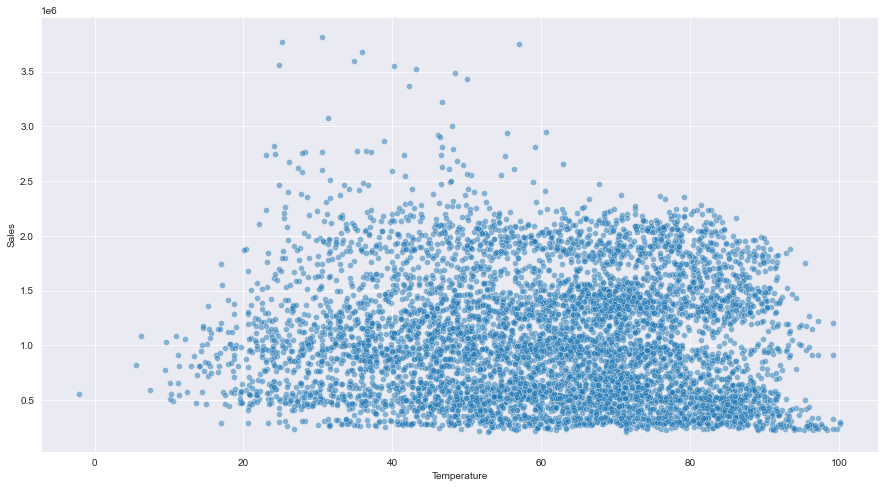

In [47]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x='Temperature', y='Sales', alpha=0.5)

There are clear tapering clusters in the plot, however temperature data can have major bias due to location and since the location data for each store was not provided its unclear how much of an effect it has.

<AxesSubplot:xlabel='CPI', ylabel='Sales'>

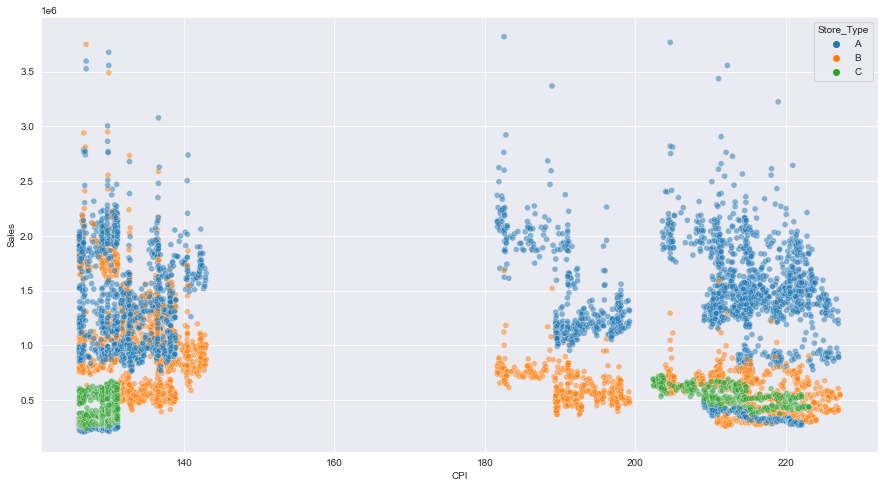

In [48]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x='CPI', y='Sales', hue='Store_Type', alpha=0.5)

At first glance there seems to be a missing cluster in the data around 150-170 CPI, oThe missing values (NaNs) present within the data could account for this loss, but it is unlikely.

<AxesSubplot:xlabel='Unemployment', ylabel='Sales'>

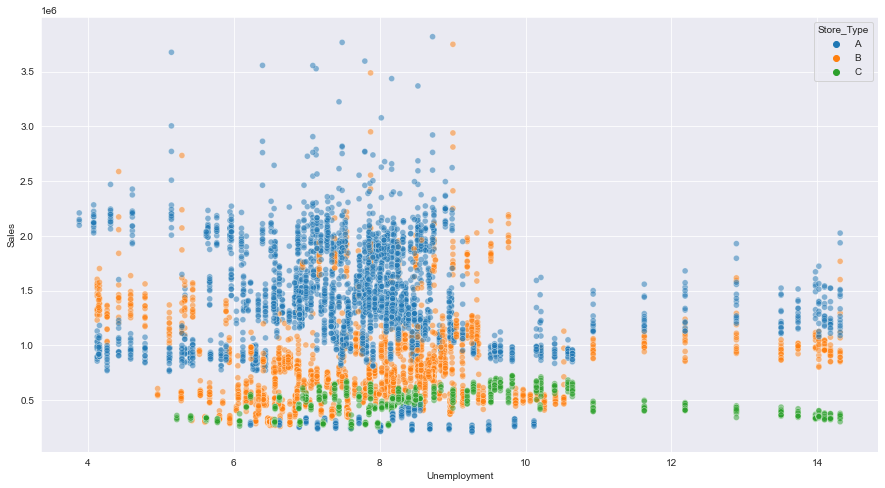

In [49]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x='Unemployment', y='Sales', hue='Store_Type', alpha=0.5)

The vast majority of sales occurred in areas where the unemployment ranged between 6 and 9 percent.

As stated in the Temperature vs Sales graph a bias exists within the data based on location, a very significant variable which we have no way to account for. There does seem to be clustering around each of the given features but the significance of each relationship must be investigated further to ascertain how important each are.

# Linear Regression

In [50]:
# In order to prep the data for regression modelling the [IsHoliday] column will be split into
# two seperate columns which check the status as either 'Holiday' or 'Not_Holiday'. 
Holiday_Check = pd.get_dummies(df['IsHoliday'])
df = pd.concat([df, Holiday_Check], axis=1)
# The same will be done for Store Type
Store_Type_Dummy = pd.get_dummies(df['Store_Type'])
df = pd.concat([df, Store_Type_Dummy], axis=1)

In [51]:
#Fix Column Headers for new Holiday and Story Type columns
df.columns = ['Store','Date','Store_Type','Temperature','Fuel_Price','CPI','Unemployment','Sales','Is_Holiday','Holiday_True','Holiday_False','Store_A','Store_B','Store_C']

In [52]:
df.head()

,Store,Date,Store_Type,Temperature,Fuel_Price,CPI,Unemployment,Sales,Is_Holiday,Holiday_True,Holiday_False,Store_A,Store_B,Store_C
0,1,2010-02-05,A,42.31,2.572,211.096358,8.106,1643690.90,False,1,0,1,0,0
1,1,2010-02-12,A,38.51,2.548,211.242170,8.106,1641957.44,True,0,1,1,0,0
2,1,2010-02-19,A,39.93,2.514,211.289143,8.106,1611968.17,False,1,0,1,0,0
3,1,2010-02-26,A,46.63,2.561,211.319643,8.106,1409727.59,False,1,0,1,0,0
4,1,2010-03-05,A,46.50,2.625,211.350143,8.106,1554806.68,False,1,0,1,0,0


In [53]:
#Dropping original summied columns
df.drop(['Store_Type','Is_Holiday'], axis=1, inplace=True)

In [54]:
regression_data = df[['Store','Temperature','Fuel_Price','CPI','Unemployment','Sales','Holiday_True','Holiday_False','Store_A','Store_B','Store_C']]

In [55]:
dependent_vars = regression_data['Sales']
independent_vars = regression_data[['Store','Temperature','Fuel_Price','CPI','Unemployment','Holiday_True','Holiday_False','Store_A','Store_B','Store_C']]
#add a constant column for the regression
independent_vars['constant'] = ones((independent_vars.shape[0],))

In [56]:
#ensure all data is numeric
dependent_vars = dependent_vars.apply(float)
independent_vars = independent_vars.applymap(float)

In [57]:
#proceed with the linear regression
lin_reg = sm.OLS(dependent_vars, independent_vars)
reg_results = lin_reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     671.4
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:23:12   Log-Likelihood:                -92397.
No. Observations:                6435   AIC:                         1.848e+05
Df Residuals:                    6426   BIC:                         1.849e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Store         -1.432e+04    482.974    -29.641

Looking at the P values produced by both [Fuel Price] and [Unemployment] are, in comparison, quite high, but of major concern are the massive negative coefficients present in [Store], [Temperature], [CPI], and [Unemployment]. To improve the model these columns will be cut (including [Fuel_Price]), and the regression rerun to see if we can get a stronger relationship, (Adjusted R-Squared Value)

In [58]:
#Above steps are repeated for new model

regression_data = df[['Store','Temperature','Fuel_Price','CPI','Unemployment','Sales','Holiday_True','Holiday_False','Store_A','Store_B','Store_C']]
dependent_vars = regression_data['Sales']
independent_vars = regression_data[['Holiday_True','Holiday_False','Store_A','Store_B','Store_C']]
#add a constant column for the regression
independent_vars['constant'] = ones((independent_vars.shape[0],))
#ensure all data is numeric
dependent_vars = dependent_vars.apply(float)
independent_vars = independent_vars.applymap(float)
#proceed with the linear regression
lin_reg = sm.OLS(dependent_vars, independent_vars)
reg_results = lin_reg.fit()
print(reg_results.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     927.3
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:23:12   Log-Likelihood:                -92887.
No. Observations:                6435   AIC:                         1.858e+05
Df Residuals:                    6430   BIC:                         1.858e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Holiday_True  -1.636e+17   2.83e+17     -0.578

<ipython-input-58-e8001e6d3d70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  independent_vars['constant'] = ones((independent_vars.shape[0],))


Its clear that dropping these columns had a significantly detrimental effect on the model, the next iteration will only remove [Fuel_Price] and [Unemployment] which were the P value outliers.

In [59]:
#Above steps are repeated for new model

regression_data = df[['Store','Temperature','Fuel_Price','CPI','Unemployment','Sales','Holiday_True','Holiday_False','Store_A','Store_B','Store_C']]
dependent_vars = regression_data['Sales']
independent_vars = regression_data[['Store','Temperature','CPI','Holiday_True','Holiday_False','Store_A','Store_B','Store_C']]
#add a constant column for the regression
independent_vars['constant'] = ones((independent_vars.shape[0],))
#ensure all data is numeric
dependent_vars = dependent_vars.apply(float)
independent_vars = independent_vars.applymap(float)
#proceed with the linear regression
lin_reg = sm.OLS(dependent_vars, independent_vars)
reg_results = lin_reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     891.8
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:23:12   Log-Likelihood:                -92403.
No. Observations:                6435   AIC:                         1.848e+05
Df Residuals:                    6428   BIC:                         1.849e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Store         -1.435e+04    479.926    -29.909

<ipython-input-59-c5cd4d94e834>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  independent_vars['constant'] = ones((independent_vars.shape[0],))


After iterating through the initial model remains the best regression available to us, with an adjusted R-Squared value of 0.455. This value indicated that there is a relationship between these variables and sales but not as significant as we would hope for. In order to create a stronger model significantly more data could be added,  in the form of new features (like location), stores tracked (Walmart had 3868 stores in the USA in 2012) and available data points.

# Sales Prediction Model

## Intro and Data Prep

Originally the entire dataset provided by Walmart was split into "Stores", "Features", "Train" and "Test". Although the data had predetermined train and test sets they were not comprehensive with the "Train" set only having [Store], [Dept], [Date], [Weekly_Sales] and the [IsHoliday] columns, so the previously aggregated table, which includes all features and store type, will be used to train and test the data. For the model using SKLearn the [Date], which was not used in the previous model, will be converted into several new features which identify which quarter the data was collected.

In [60]:
#To prepare the data for modelling the date will be changed into a quarterly check similar to the above store type check
Date = df['Date'].dt
Date.month

0        2
1        2
2        2
3        2
4        3
        ..
6430     9
6431    10
6432    10
6433    10
6434    10
Name: Date, Length: 6435, dtype: int64

In [61]:
#set for identifying each month as Q1 -4
map = {1: 'Q1', 2: 'Q1', 3: 'Q1',4: 'Q2',5: 'Q2',6: 'Q2',7: 'Q3',8: 'Q3',9: 'Q3',10: 'Q4',11: 'Q4',12: 'Q4'}

In [62]:
df['Quarter'] = df['Date'].apply(lambda x: map[x.month])

In [63]:
df.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Sales,Holiday_True,Holiday_False,Store_A,Store_B,Store_C,Quarter
0,1,2010-02-05,42.31,2.572,211.096358,8.106,1643690.90,1,0,1,0,0,Q1
1,1,2010-02-12,38.51,2.548,211.242170,8.106,1641957.44,0,1,1,0,0,Q1
2,1,2010-02-19,39.93,2.514,211.289143,8.106,1611968.17,1,0,1,0,0,Q1
3,1,2010-02-26,46.63,2.561,211.319643,8.106,1409727.59,1,0,1,0,0,Q1
4,1,2010-03-05,46.50,2.625,211.350143,8.106,1554806.68,1,0,1,0,0,Q1


In [64]:
#One-Hot Encoding will be used to create new columns for Q1-4
Store_Type_Dummy = pd.get_dummies(df['Quarter'])
df = pd.concat([df, Store_Type_Dummy], axis=1)
#Drop the Date and Quarter column
df = df.drop(labels=['Date','Quarter'], axis =1)

In [65]:
df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,Sales,Holiday_True,Holiday_False,Store_A,Store_B,Store_C,Q1,Q2,Q3,Q4
0,1,42.31,2.572,211.096358,8.106,1643690.90,1,0,1,0,0,1,0,0,0
1,1,38.51,2.548,211.242170,8.106,1641957.44,0,1,1,0,0,1,0,0,0
2,1,39.93,2.514,211.289143,8.106,1611968.17,1,0,1,0,0,1,0,0,0
3,1,46.63,2.561,211.319643,8.106,1409727.59,1,0,1,0,0,1,0,0,0
4,1,46.50,2.625,211.350143,8.106,1554806.68,1,0,1,0,0,1,0,0,0


## Linear Regression

In [66]:
correlationAnalysis = df.corr()
correlationAnalysis

,Store,Temperature,Fuel_Price,CPI,Unemployment,Sales,Holiday_True,Holiday_False,Store_A,Store_B,Store_C,Q1,Q2,Q3,Q4
Store,1.000000e+00,-0.022659,0.060023,-0.209492,0.223531,-0.335332,-2.023981e-15,-4.386841e-16,-5.819143e-02,-2.788104e-01,4.832242e-01,-3.829054e-17,2.002340e-15,7.560501e-16,2.417216e-16
Temperature,-2.265908e-02,1.000000,0.144982,0.176888,0.101158,-0.063810,1.550913e-01,-1.550913e-01,1.934692e-02,-1.220972e-01,1.456913e-01,-5.278635e-01,1.736416e-01,5.590582e-01,-2.569350e-01
Fuel_Price,6.002295e-02,0.144982,1.000000,-0.170642,-0.034684,0.009464,7.834652e-02,-7.834652e-02,-2.984328e-02,3.317139e-02,-3.425901e-03,-1.083792e-01,1.887656e-01,3.328832e-02,-1.294685e-01
CPI,-2.094919e-01,0.176888,-0.170642,1.000000,-0.302020,-0.072634,2.162091e-03,-2.162091e-03,7.211513e-02,-6.815583e-02,-8.838630e-03,-5.462196e-03,-1.074511e-03,6.230492e-03,-4.058529e-05
Unemployment,2.235313e-01,0.101158,-0.034684,-0.302020,1.000000,-0.106176,-1.096028e-02,1.096028e-02,-1.011063e-01,-3.376551e-02,1.968357e-01,1.845142e-02,7.609430e-03,-2.445507e-02,-4.515226e-04
Sales,-3.353320e-01,-0.063810,0.009464,-0.072634,-0.106176,1.000000,-3.689097e-02,3.689097e-02,5.714130e-01,-3.092485e-01,-3.992017e-01,-3.962767e-02,-6.682838e-03,-2.618669e-02,7.626825e-02
Holiday_True,-2.023981e-15,0.155091,0.078347,0.002162,-0.010960,-0.036891,1.000000e+00,-1.000000e+00,1.016956e-16,9.448390e-16,-1.496393e-15,-4.505636e-02,1.679151e-01,-1.238864e-02,-1.219230e-01
Holiday_False,-4.386841e-16,-0.155091,-0.078347,-0.002162,0.010960,0.036891,-1.000000e+00,1.000000e+00,5.912435e-18,1.580487e-16,-2.338780e-16,4.505636e-02,-1.679151e-01,1.238864e-02,1.219230e-01
Store_A,-5.819143e-02,0.019347,-0.029843,0.072115,-0.101106,0.571413,1.016956e-16,5.912435e-18,1.000000e+00,-7.620665e-01,-3.836107e-01,5.519255e-18,-2.099980e-16,1.839663e-17,-3.798590e-17
Store_B,-2.788104e-01,-0.122097,0.033171,-0.068156,-0.033766,-0.309248,9.448390e-16,1.580487e-16,-7.620665e-01,1.000000e+00,-3.056249e-01,-1.399932e-17,-6.040393e-16,-2.933323e-16,2.072660e-18


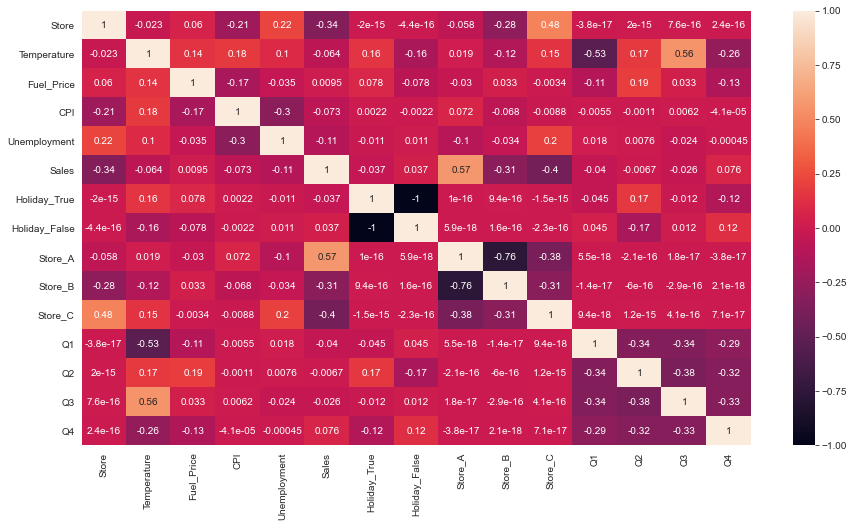

In [67]:
# Resizing trick from matplotlib
plt.figure(figsize=(15,8))

# setting the annot argument to "True" to display labels
sns.heatmap(correlationAnalysis,annot=True)
plt.savefig('CoEfficient_HeatMap.png')

In [68]:
#rechecking data types for Regression
df.dtypes

Store              int64
Temperature      float64
Fuel_Price       float64
CPI              float64
Unemployment     float64
Sales            float64
Holiday_True       uint8
Holiday_False      uint8
Store_A            uint8
Store_B            uint8
Store_C            uint8
Q1                 uint8
Q2                 uint8
Q3                 uint8
Q4                 uint8
dtype: object

In [69]:
# including all previous columns, only dropping the dependent variable 'Sales'
X = df.drop(labels='Sales', axis=1)

# ensuring our y (prediction) is only included
y = df['Sales']

In [70]:
# the 'test_size' parameter is where we'll change our ratio mentioned above
# 'random state' refers to the 'seed' used to ensure we have the same starting point each time we run this model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7500)

In [71]:
#Printing shape to see the 1/4 to 3/4 split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4826, 14)
(1609, 14)
(4826,)
(1609,)


In [72]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

<AxesSubplot:>

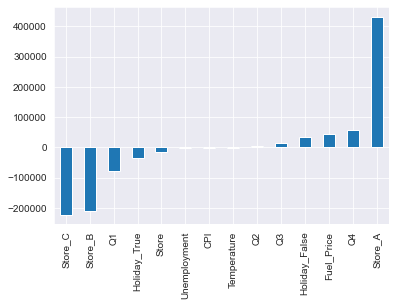

In [73]:
coeff = pd.Series(data=lr.coef_, index=X.columns).sort_values()
coeff.plot(kind='bar')

In [74]:
#Model Test
y_pred = lr.predict(X_test)

In [75]:
# calculating MSE; closer to zero is better
print('MSE:',np.round(mt.mean_squared_error(y_test,y_pred),2))

# calculating R-Square; closer to 1 is better
print('R-Square:',np.round(mt.r2_score(y_test,y_pred),2))

MSE: 178182990541.18
R-Square: 0.44


An R-Squared value of 0.44 is an okay starting point but hopefully with either mode data, features or iterations a stronger relationship could be found.

Although the value of MSE seems high since we are dealing with sales figures in the millions per week a ME of 422 thousand is within an acceptable range.

In [98]:
#setting CLF for decision tree regressor
clf = DecisionTreeRegressor(max_depth=2, random_state=7500)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=7500)

[Text(418.5, 362.4, 'Holiday_False <= 0.5\nmse = 318754990439.104\nsamples = 4826\nvalue = 1049971.843'),
 Text(209.25, 217.44, 'CPI <= 189.26\nmse = 148411126698.916\nsamples = 2464\nvalue = 728880.749'),
 Text(104.625, 72.47999999999996, 'mse = 199637515556.187\nsamples = 1368\nvalue = 876827.403'),
 Text(313.875, 72.47999999999996, 'mse = 23050746109.695\nsamples = 1096\nvalue = 544217.407'),
 Text(627.75, 217.44, 'Store <= 31.5\nmse = 276707029199.99\nsamples = 2362\nvalue = 1384928.852'),
 Text(523.125, 72.47999999999996, 'mse = 177922714272.481\nsamples = 1621\nvalue = 1595424.874'),
 Text(732.375, 72.47999999999996, 'mse = 183837496387.942\nsamples = 741\nvalue = 924451.048')]

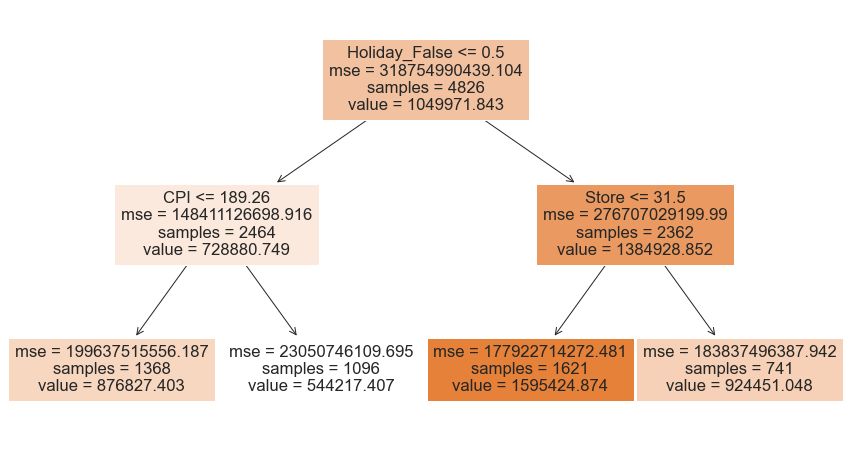

In [99]:
#visual of the Decision tree
plt.figure(figsize=(15,8))
plot_tree(clf, feature_names=df.columns, filled=True)

## Cross Validation

In [ ]:
cross_val_score(lr, X_train, y_train, cv=5)

In [ ]:
np.mean(cross_val_score(lr, X_train, y_train, cv=5))

The 5 folds averaged to 0.465 which is very similar to our R-Squared value of 0.44

# Conclusion

In conclusion a predictive model for Walmart's weekly sales was created with an R-Squared value of 0.44 compared to the linear regression of 0.455 and cross validated value of 0.465. The Hypothesis is therefore accepted, there is a correlation between sales and external factors outside the control of a store. Both the model and linear regression could have been made more accurate with the addition of more data and using a Random-Forest Regressional model.


The lack of location data is a significant hurdle for this model, as it introduces significant bias which stunts our ability to further investigate. However before using the model to make insightful analysis or predictions more data is needed. A greater time period, location data, more monitored features and the meta data would significantly enhance our ability to create an accurate model.


